<a href="https://colab.research.google.com/github/chetrajpandey/advanced_topics_in_deep_learning/blob/main/Assignment3_Chetraj_Pandey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<font size="5"><div class="alert alert-info">
Chetraj Pandey | Assignment THREE | Advanced Topics in Deep Learning
</div></font>

---

In [ ]:
#Necessary Imports
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from matplotlib.pyplot import figure
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random, os
import torch.autograd as autograd

# Computational Node -- Either CPU or GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.backends.cudnn.benchmark = True
print('Device:', device)


# Random Seeds for Reproducibility
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(40)

Device: cuda:0


---
<font size="5"><div class="alert alert-info">
MNIST Dataset: Dataloader and [-1, +1] Normalization Pytorch
</div></font>

---

In [ ]:
#Dataset MNIST
transform_minus_one_to_plus_one = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))])


#Train_Set with 60k samples
train_set = datasets.MNIST(root='./data/', train=True, transform=transform_minus_one_to_plus_one, download=True)


print('Total Instances in Train Set: ', len(train_set))


# Dataloader -- Just an efficient way to load the dataset using pytorch is to use the dataloader
bs=100
train_loader = DataLoader(dataset=train_set, batch_size=bs, shuffle=True, num_workers=4)
# test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

# Verifying [-1,1] normalization among 5 of the batches
for batch_idx, (data, _) in enumerate(train_loader):
    print('Max: ', data.max(), 'Min: ', data.min())
    if batch_idx==4:
        break

Total Instances in Train Set:  60000
Max:  tensor(1.) Min:  tensor(-1.)
Max:  tensor(1.) Min:  tensor(-1.)
Max:  tensor(1.) Min:  tensor(-1.)
Max:  tensor(1.) Min:  tensor(-1.)
Max:  tensor(1.) Min:  tensor(-1.)


---
<font size="5"><div class="alert alert-info">
GAN (Generator and Discriminator) Definition
</div></font>


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        
        # z-space is 100-d vector
        self.fc1 = nn.Linear(z_dim, 256)
        
        # hidden layers
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        
        # final layer
        self.fc4 = nn.Linear(1024, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = torch.tanh(self.fc4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        
        #Using default negative_slope=0.01
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

---
<font size="5"><div class="alert alert-info">
Load Model to GPU, Optimizer, Loss Function and Hyperparameters
</div></font>

---

In [ ]:
# Load network to memory
z_dim = 100
G = Generator(z_dim=z_dim).to(device)
D = Discriminator().to(device)
print(G, D)

# # Loss function -- without the sigmoid
# criterion = nn.BCELoss() 


# Optimizer - Adam
lr = 0.01
G_optimizer = optim.SGD(G.parameters(), lr = lr, weight_decay=0.0001)
D_optimizer = optim.SGD(D.parameters(), lr = lr, weight_decay=0.0001)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
) Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


---
<font size="5"><div class="alert alert-info">
Implementing Gradient Penalty
</div></font>

---

In [ ]:
def get_gradient_penalty(discriminator, real_images, gen_images, LAMBDA=10):
    epsilon = torch.rand(bs, 1)
    epsilon = epsilon.expand(real_images.size())
    epsilon = epsilon.to(device)

    x_hat = epsilon * real_images + ((1 - epsilon) * gen_images)
    x_hat.to(device)
    x_hat = Variable(x_hat, requires_grad=True)

    disc_x_hat = discriminator(x_hat)

    gradients = autograd.grad(outputs=disc_x_hat, inputs=x_hat,
                              grad_outputs=torch.ones(disc_x_hat.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

---
<font size="5"><div class="alert alert-info">
Training WGAN-GP
</div></font>

---

In [ ]:
def train_WGAN_GP():
    
    d_loss_val, g_loss_val=0. , 0.
    G.train()
    D.train()
    for batch_idx, (x, _) in enumerate(train_loader):

        # DISCRIMINATOR NETWORK TRAINING
        
        
        # Generating Batch of Samples using the Generator
        z = Variable(torch.randn(bs, z_dim).to(device))
        gen_images = G(z).detach()
        
        
        # Sampling batch of images from the dataset
        real_images = Variable(x.view(-1, 784).to(device))
        
        
        #Computing Discriminator Loss and Optimizing the Discriminator
        D_loss = D(gen_images).mean() - D(real_images).mean() + get_gradient_penalty(D, real_images, gen_images)
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        
        # GENERATOR NETWORK TRAINING
        

        # Generating Batch of Samples using the Generator
        z = Variable(torch.randn(bs, z_dim).to(device))
        
        #Computing Generator Loss and Optimizing the Generator
        G_loss = -D(G(z)).mean()
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        #Aggregating Total loss of entire dataset for generator and discriminator
        d_loss_val+=D_loss.item() 
        g_loss_val+=G_loss.item()

    #Final Aggregated Loss   
    d_loss_val /= (len(train_loader.dataset)/bs)
    g_loss_val /= (len(train_loader.dataset)/bs)
        
    return d_loss_val, g_loss_val

In [ ]:
loss_values = []
for epoch in range(0, 250):
    d_loss, g_loss = train_WGAN_GP()
    loss_values.append([d_loss, g_loss])
    # print('Epoch: ', epoch+1, '|' 'Dis. loss: {:.4f} | Gen. Loss: {:.4f}'.format(d_loss, g_loss))
    if epoch == 0:
        print('Epoch: ', epoch+1, '|' 'Dis. loss: {:.4f} | Gen. Loss: {:.4f}'.format(d_loss, g_loss))
    if epoch%25 == 0 and epoch!=0:
        print('Epoch: ', epoch, '|' 'Dis. loss: {:.4f} | Gen. Loss: {:.4f}'.format(d_loss, g_loss))



Epoch:  1 |Dis. loss: -9.5379 | Gen. Loss: -3.4541
Epoch:  25 |Dis. loss: -3.0727 | Gen. Loss: -1.4023
Epoch:  50 |Dis. loss: -1.8709 | Gen. Loss: -2.1887
Epoch:  75 |Dis. loss: -1.4979 | Gen. Loss: -2.1698
Epoch:  100 |Dis. loss: -1.2854 | Gen. Loss: -2.3707
Epoch:  125 |Dis. loss: -1.1925 | Gen. Loss: -2.3566
Epoch:  150 |Dis. loss: -1.1021 | Gen. Loss: -2.5650
Epoch:  175 |Dis. loss: -1.0517 | Gen. Loss: -2.6771
Epoch:  200 |Dis. loss: -1.0089 | Gen. Loss: -2.6832
Epoch:  225 |Dis. loss: -0.9819 | Gen. Loss: -2.8169


---
<font size="5"><div class="alert alert-info">
Training curves (Discriminator and Generator loss vs epochs)
</div></font>

---

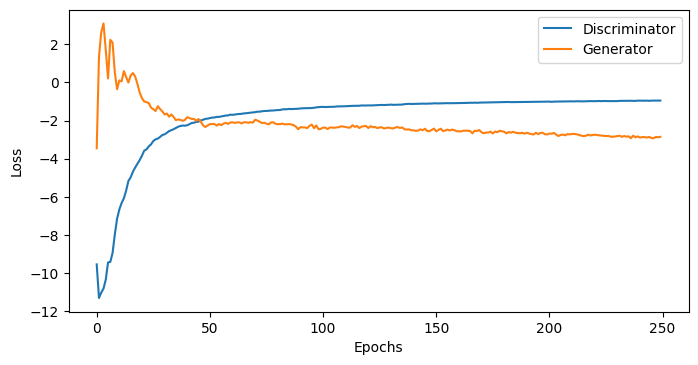

In [ ]:
# Training curves (loss vs epochs)
figure(figsize=(8, 4), dpi=100)
def plot_results(disc_loss, gen_loss):
    plt.plot(disc_loss, label='Discriminator')
    plt.plot(gen_loss, label='Generator')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_results([item[0] for item in loss_values], [item[1] for item in loss_values]) 

---
<font size="5"><div class="alert alert-info">
A 10 x 10 grid plot of 100 randomly generated images which are the outputs
of the Generator.
</div></font>

---

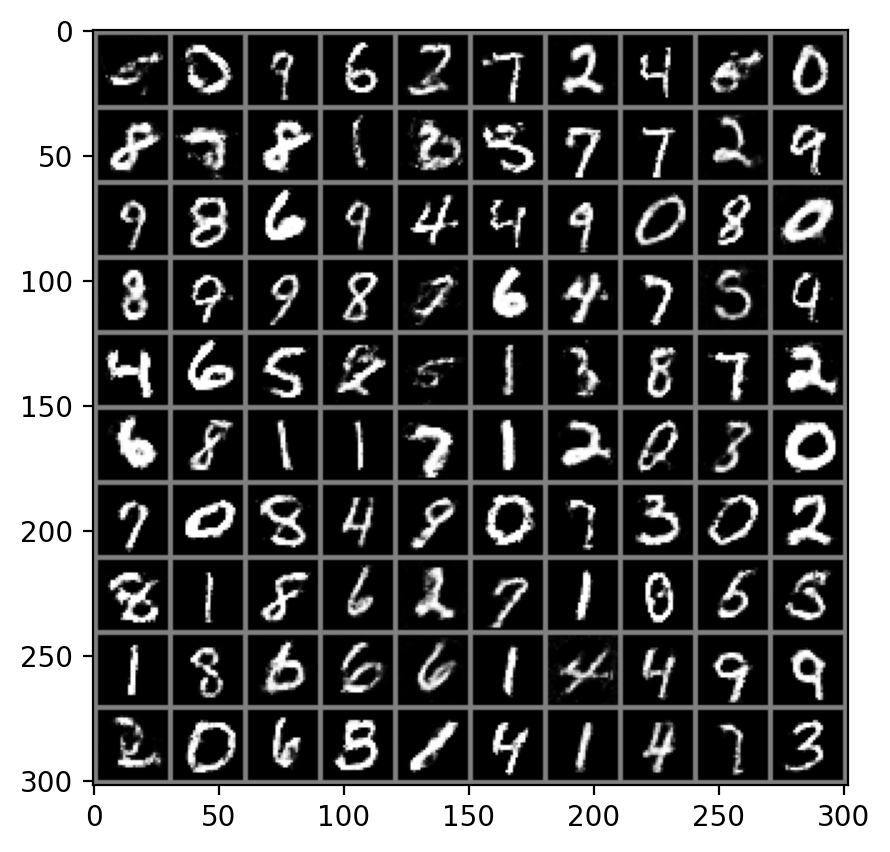

In [ ]:
figure(figsize=(5, 5), dpi=200)
def show_images(images, nrow):
    images = torchvision.utils.make_grid(images, nrow=nrow)
    plt.imshow(images[0], cmap='gray')
    plt.show()
G.eval()   
with torch.no_grad():
    random_z = Variable(torch.randn(bs, z_dim).to(device))
    generated_imgs = G(random_z)
    show_images(generated_imgs.cpu().view(generated_imgs.size(0), 1, 28, 28), 10)